In [9]:
import pandas as pd
from sklearn.base import BaseEstimator
import numpy as np
#Para convertir el dataset de atributos categoricos a numericos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray

#################STAGE 1: DATASET SELECTION -> Chess End-Game -- King+Rook versus King+Pawn on a7
# load dataset 
dataset =pd.read_csv("chess.txt", header=None)

#Attribute 36 -> targets
###############STAGE 2: PRE-PROCESSING //// NO MISSING VALUES
#DATASET REINDEX================================
random_index = [0 for x in range(dataset.shape[0])]
for i in range(0, dataset.shape[0]):
    random_index[i]=i
np.random.shuffle(random_index) #REVOLVER INDICES DEL ARRAY
#DATASET REINDEX
dataset = pd.DataFrame(dataset)
dataset = dataset.reindex(index=random_index)
#CONVERTIR A MATRIZ PARA REINICIAR INDICES DE LAS NUEVAS FILAS
dataset = dataset.as_matrix()
#CONVERTIR A DATAFRAME DE NUEVO UNA VEZ REINICIADOS LOS INDICES CON LAS NUEVAS FILAS
dataset = pd.DataFrame(dataset)
#END DATASET REINDEX===============================

##TAKE ONLY A FEW ROWS OF THE DATASET
n_filas=500
data_chess = [[0 for x in range(dataset.shape[1] - 1)] for y in range(n_filas)]
targets_chess = [0 for x in range(n_filas)]

for i in range(0, n_filas):
    for j in range(0, dataset.shape[1]- 1):
        data_chess[i][j] = dataset.at[i,j]

for i in range(0, n_filas):
    if(dataset.at[i,36] == "won"):
        targets_chess[i] = 0
    else:
        targets_chess[i]=1

#CONVERT FROM CATEGORICAL TO NUMERIC
label_encoder = LabelEncoder()

data_chess_label_encoder = [[0 for x in range(dataset.shape[1] - 1)] for y in range(n_filas)]
#conversion de categorico a numerico con label encoder
for i in range(0, n_filas):
    data_chess_label_encoder[i] = label_encoder.fit_transform(data_chess[i])
#Aplicar one hot encoder a la transformacion de label encoder para finalizar transformacion categorica a numerica
enc = OneHotEncoder(sparse=False)
chess_oneHotEncoder = enc.fit_transform(data_chess_label_encoder)
chess_oneHotEncoder = pd.DataFrame(chess_oneHotEncoder) #NUEVO DATASET NUMERICO

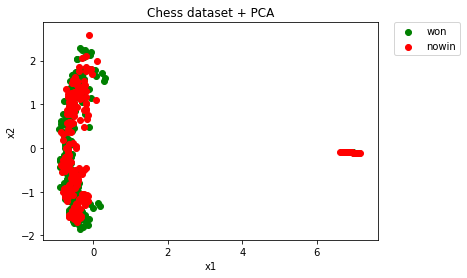

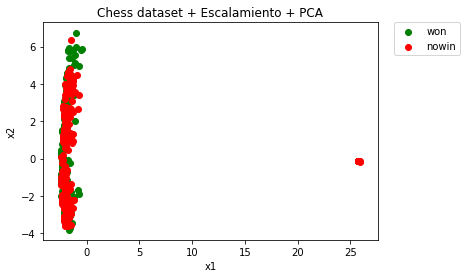

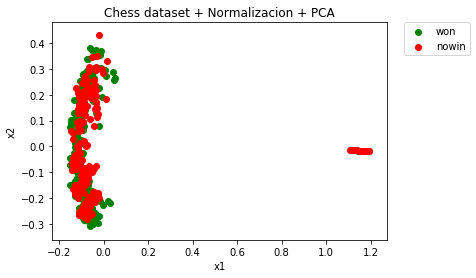

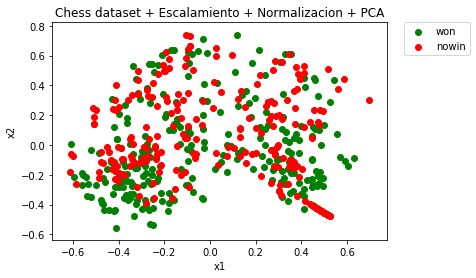

In [13]:
#Grafica de grupos
def graficar(dataset, targets, title):
    colors=['green','red']
    targets_name = ["won","nowin"]
    for i in range(len(colors)):
        x = dataset[:,0][targets==i]
        y= dataset[:,1][targets==i]
        plt.scatter(x,y,c=colors[i])
        plt.legend(targets_name,bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(title)
    plt.show()
    
%matplotlib inline
#Graficar visualizacion de datos

#Reduccion de dimensiones con PCA
pca = PCA(n_components=2)
#fit and transform the data to the model
reduce_data_pca = pca.fit_transform(chess_oneHotEncoder)

targets_chess = asarray(targets_chess)

#########################Grafica PCA solamente
graficar(reduce_data_pca, targets_chess, "Chess dataset + PCA")

########################APLICACION DE ESCALAMIENTO : GRAFICA ESCALAMIENTO + PCA
Matrix_scaled = preprocessing.scale(chess_oneHotEncoder)
pca = PCA(n_components=2)
#PCA
reduce_data_pca_e = pca.fit_transform(Matrix_scaled)
graficar(reduce_data_pca_e, targets_chess,  "Chess dataset + Escalamiento + PCA")

########################APLICACION DE NORMALIZACION: GRAFICA Normalizacion + PCA
Matrix_np = np.asanyarray(chess_oneHotEncoder)
Matrix_normalizada = preprocessing.normalize(Matrix_np, norm='l2')
#PCA
pca = PCA(n_components=2)
reduce_data_pca_n = pca.fit_transform(Matrix_normalizada)
graficar(reduce_data_pca_n, targets_chess,  "Chess dataset + Normalizacion + PCA")

########################APLICACION DE ESCALAMIENTO Y NORMALIZACION: GRAFICA Escalamiento + Normalizacion + PCA
Matrix_np_2 = np.asanyarray(Matrix_scaled)
Matrix_normalizada_2 = preprocessing.normalize(Matrix_np_2, norm='l2')
#PCA
pca = PCA(n_components=2)
reduce_data_pca_e_n = pca.fit_transform(Matrix_normalizada_2)
graficar(reduce_data_pca_e_n, targets_chess,  "Chess dataset + Escalamiento + Normalizacion + PCA")

In [14]:
#NaiveBayes
class Bayes(BaseEstimator):
    dataset = [] #dataset
    targets = [] #array contenedor de las etiquetas de cada registro del dataset
    targets_name = [] #array contenedor de todas las posibles etiquetas
    new_tuple = [] #nuevo registro: Contenedor de F1..Fn (atributos)
    aProbF = [] #array contenedor de probabilidades de Fs (columnas del dataset)
    aProbC = [] #array contenedor de probabilidades de C (todas las posibles etiquetas)
    aProbC_new_tuple = [] #array contenecdor de probabilidades de C (respecto al nuevo registro)
    
    #Constructor recibe como parametros:
    def __init__(self, targets_name):
        self.targets_name = targets_name
    
    def fit(self, X, y):
        self.dataset = self.verifyType(X)
        self.targets = y
        self.initArrays()
        for i in range(0, len(self.targets_name)):
            cont = 0.0
            for j in range(0, len(self.targets)):
                if(self.targets_name[i] == self.targets[j]):
                    cont = cont + 1.0
            self.aProbC[i] = cont / len(self.targets)
        return self
 
    def predict_proba(self, X):
        y = [[0.0 for x in range(2)] for y in range( len(X) )]
        for i in range(0, len(X) ):
            y[i] = self.perform(X[i])
        y = asarray(y)
        return y
     
    #funcion que verifica si el dataset recibido como parametro es de tipo DataFrame, si no es asi, se convierte a este tipo
    def verifyType(self, X):
        if(not type(X)==pd.DataFrame):
            X = pd.DataFrame(data=X)
        return X
    #Funcion que inicializa los arrays de probabilidades
    def initArrays(self):
        self.aProbF = [0.0 for x in range(self.dataset.shape[1])]
        self.aProbC = [0.0 for x in range(len(self.targets_name))]
        self.aProbC_new_tuple = [0.0 for x in range(len(self.targets_name))]
        
    #Funcion que ejecuta el algoritmo
    def perform(self, new_tuple):
        for x in range(0, len(self.targets_name)):
            cont = 0.0
            self.aProbF = [0.0 for d in range(self.dataset.shape[1])]
            for i in range(0, self.dataset.shape[0]):
                if(self.targets_name[x]==self.targets[i]):
                    cont = cont + 1.0
                    for j in range(0, self.dataset.shape[1]):
                        if(self.dataset.at[i,j] == new_tuple[j]):
                            self.aProbF[j] = self.aProbF[j] + 1.0
            self.exProbFandC(cont,x)
        return self.getLabel()
        
    #Funcion que calcula las probabilidades de cada etiqueta posible
    def exProbFandC(self, norm, indC):
        acum = 1.0
        for i in range(0, len(self.aProbF)):
            self.aProbF[i] = self.aProbF[i] / norm
            acum = acum * self.aProbF[i]
        self.aProbC_new_tuple[indC] = self.aProbC[indC] * acum
    
    #Funcion que retorna la etiqueta con la probabilidad mas alta
    def getLabel(self):
        probs = [0.0 for x in range(2)]
        probs[0] = self.aProbC_new_tuple[0]
        probs[1] = self.aProbC_new_tuple[1]
        return probs

In [15]:
#ROC function

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


def graficar_roc(X, y, n_folds, classifier, titleGraph):
    if(not type(X) == pd.DataFrame ):
        X = pd.DataFrame(X)
    n_samples, n_features = X.shape
    # Add noisy features
    random_state = np.random.RandomState(0)
    X = np.c_[X, random_state.randn(n_samples,0)]
    # Classification and ROC analysis
    cv = StratifiedKFold(n_splits=n_folds)
    #classifier = svm.SVC(kernel='linear', probability=True,
     #                    random_state=random_state)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titleGraph)
    plt.legend(loc="lower right")
    plt.show()
    

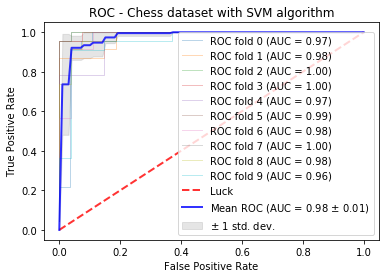

In [19]:
#ROC WITH SVM
random_state = np.random.RandomState(0)
classifier =svm.SVC(kernel='linear', probability=True,random_state=random_state)
graficar_roc(chess_oneHotEncoder, targets_chess, 10, classifier, "ROC - Chess dataset with SVM algorithm")

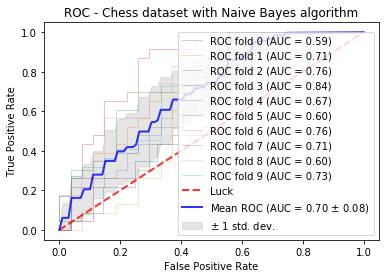

In [20]:
#ROC WITH NAIVE BAYES
targets_name_chess = [0,1]
classifier = Bayes(targets_name_chess)
graficar_roc(data_chess, targets_chess, 10, classifier, "ROC - Chess dataset with Naive Bayes algorithm")

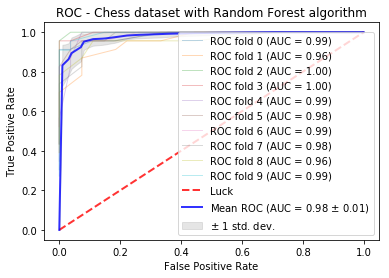

In [21]:
#ROC WITH RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
graficar_roc(chess_oneHotEncoder, targets_chess, 10, classifier, "ROC - Chess dataset with Random Forest algorithm")